In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import os
import wandb
import seaborn as sns
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



wandb.login(key="8a88a8c49d1c2d31b8677fe0b8eb7d3e3a031f83")
api = wandb.Api()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /export/home/0schindl/.netrc
wandb: Currently logged in as: belaschindler (belaschindler-university-hamburg) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [2]:
def gini_coefficient_formula(task_counts):
    array = np.sort(np.array(task_counts))
    n = array.shape[0]
    index = np.arange(1, n + 1)
    if np.sum(array) == 0:
        return 0.0
    return ((np.sum((2 * index - n - 1) * array)) / (n * np.sum(array)))

def get_expert_distribution(run):
    if run.state != "finished":
        return None

    history = run.history()
    
    expert_distributions = dict()
    ft_tasks = [None] * 1000
    ft_buffer = run.config.get("moe_max_experts")
    for line in run.history().columns:
        if line.startswith("Expert") and line.endswith("learned task"):
            
            line_splited = line.split(" ")
            expert = int(line_splited[1])
            tasks = history[line].dropna().tolist()
            tasks = [int(task) for task in tasks]
            
            if expert not in expert_distributions:
                expert_distributions[expert] = list()
            expert_distributions[expert].extend(tasks) 

            
            for i in tasks:
                if i >= ft_buffer:
                    ft_tasks[i - ft_buffer] = expert    

    # cleaning ft_tasks
    ft_tasks = [i for i in ft_tasks if i is not None]

    return ft_tasks, expert_distributions

def get_sweep_data(runs, attributes_config=[], attributes_summary=[], include_run_id=True, gini=False):
    sweep_data = []
    for run in runs:
        config = run.config
        summary = run.summary

        if summary.get("task_mean/acc") is not None and run.state == "finished":
            run_data = dict()
            if include_run_id:
                run_data["run_id"] = run.id
            # Add the config attributes to the run_data dictionary
            for attr in attributes_config:
                run_data[attr] = config.get(attr)

            # Add the summary attributes to the run_data dictionary
            for attr in attributes_summary:
                run_data[attr] = summary.get(attr)
            
            # gini coefficient
            if gini:
                _, task_distribution = get_expert_distribution(run)
                task_distribution_list = [len(task_distribution[i]) - 1 for i in task_distribution.keys()]
                run_data["gini"] = gini_coefficient_formula(task_distribution_list)

            sweep_data.append(run_data)

    return sweep_data

In [3]:
_42_adapter_performance = [
    "belaschindler-university-hamburg/0schindl-LayUp_sweeps_question1_results/6kim8tiu", # DIL
    "belaschindler-university-hamburg/0schindl-LayUp_sweeps_question1_results/jdpa9z1x", # Cars
    "belaschindler-university-hamburg/0schindl-LayUp_sweeps_question1_results/cjddpel4", # Imagenet-a
    "belaschindler-university-hamburg/0schindl-LayUp_sweeps_question1_results/hxigp6ck", # Imagenet-r
    "belaschindler-university-hamburg/0schindl-LayUp_sweeps_question1_results/p7zmthx9", # CIL
    ]
datsets_in_CIL = ["cifar100", "cub", "vtab", "omnibenchmark"]


table_421 = []
for i, s in enumerate(_42_adapter_performance):
    sweep = api.sweep(s)
    runs = sweep.runs

    attributes_config = ["dataset", "selection_method"]
    attributes_summary = ["task_mean/acc"]

    data = get_sweep_data(runs, attributes_config, attributes_summary)
    for e in data:
        if i == 4:
            # CIL
            if e["dataset"] in datsets_in_CIL:
                table_421.append(e)
        else:
            table_421.append(e)



df_sweep = pd.DataFrame(table_421)
#print("\nDataFrame der Sweep-Runs:")
#print(df_sweep)
average_accuracy_per_dataset = df_sweep.groupby('dataset')['task_mean/acc'].mean().round(3) * 100
print(average_accuracy_per_dataset)


dataset
cars                 34.4
cddb                 59.6
cifar100             77.1
cub                  72.5
dil_imagenetr        68.8
imageneta            39.5
imagenetr            66.3
limited_domainnet    45.0
omnibenchmark        58.6
vtab                 78.2
Name: task_mean/acc, dtype: float64


In [3]:
_43_selection_method = [
    "belaschindler-university-hamburg/0schindl-LayUp_sweeps_question1_selection_method/wk4w5q0t", # CIL
    "belaschindler-university-hamburg/0schindl-LayUp_sweeps_question1_selection_method/6uix7luf", # CIL cosine
    "belaschindler-university-hamburg/0schindl-LayUp_sweeps_question1_selection_method/lpeje9a7"  # DIL
    ]
datsets_in_CIL = ["cifar100", "cub", "vtab", "omnibenchmark", "imageneta"]

table_431 = []
for i , s in enumerate(_43_selection_method):
    sweep = api.sweep(s)
    runs = sweep.runs

    attributes_config = ["dataset", "selection_method"]
    attributes_summary = ["task_mean/acc"]

    data = get_sweep_data(runs, attributes_config, attributes_summary, include_run_id=False)
    for e in data:
        if i == 0:
            if e["dataset"] in datsets_in_CIL:
                table_431.append(e)
        else:
            table_431.append(e)

df_sweep = pd.DataFrame(table_431)
df_sweep["task_mean/acc"] = df_sweep["task_mean/acc"].astype(float).round(3) * 100
pd.set_option('display.max_rows', None)
print(df_sweep)


              dataset selection_method  task_mean/acc
0                vtab       inv_ws_div           78.4
1                vtab           ws_div           78.4
2                vtab       inv_kl_div           78.4
3                vtab           kl_div           78.4
4                vtab   inv_eucld_dist           78.4
5                vtab       eucld_dist           78.4
6                vtab           around           78.4
7            cifar100       inv_ws_div           78.1
8            cifar100           ws_div           77.0
9            cifar100       inv_kl_div           77.3
10           cifar100           kl_div           77.0
11           cifar100   inv_eucld_dist           77.4
12           cifar100       eucld_dist           77.0
13           cifar100           around           77.2
14      omnibenchmark       inv_ws_div           59.0
15      omnibenchmark   inv_eucld_dist           56.4
16      omnibenchmark           ws_div           58.8
17      omnibenchmark       

In [4]:
pivot_df = df_sweep.pivot(index='selection_method', columns='dataset', values='task_mean/acc')

# Reset des Index, um 'selection_method' als normale Spalte zu erhalten
pivot_df = pivot_df.reset_index()

# Anzeigen des transformierten DataFrames
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', None):
    print(pivot_df)


dataset selection_method  cars  cddb  cifar100   cub  dil_imagenetr  \
0                 around  33.5  61.7      77.2  72.2           66.8   
1             eucld_dist  35.7  61.7      77.0  72.6           66.5   
2         inv_eucld_dist  38.3  61.7      77.4  72.5           69.3   
3             inv_kl_div  34.7  61.7      77.3  72.7           68.4   
4             inv_ws_div  36.0  61.7      78.1  73.1           69.8   
5                 kl_div  38.3  61.7      77.0  72.6           66.0   
6                 ws_div  36.2  61.7      77.0  72.7           66.1   

dataset  imageneta  imagenetr  limited_domainnet  omnibenchmark  vtab  
0             39.7       65.9               41.7           58.8  78.4  
1             39.4       65.8               42.8           58.2  78.4  
2             40.1       67.6               42.6           56.4  78.4  
3             40.3       68.0               44.0           55.8  78.4  
4             40.0       67.0               44.7           59.0  78.4  

In [3]:
def create_colored_table(df, filename):
    print("0")
    output_folder = "local_saved_graphics"
    if not filename.endswith(".png"):
        filename = filename + ".png"
    filepath = os.path.join(output_folder, filename)

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Identify numeric columns
    numeric_df = df.select_dtypes(include='number')
    non_numeric_df = df.drop(columns=numeric_df.columns)
    print("1")
    # Create color-coded cells
    cellColours = []
    for i in range(df.shape[0]):
        row_colors = []
        for j in range(df.shape[1]):
            if df.columns[j] in numeric_df.columns:
                col = numeric_df[df.columns[j]]
                value = df.iloc[i, j]
                # Avoid divide-by-zero if min == max
                if col.max() == col.min():
                    normalized_value = 0.5
                else:
                    normalized_value = (value - col.min()) / (col.max() - col.min())
                row_colors.append(plt.cm.Blues(normalized_value))
            else:
                row_colors.append("white")  # No color for non-numeric
        cellColours.append(row_colors)
        print(f"2.{i}")
        
    print("2.x")
    # Plot table
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axis('off')
    table = ax.table(
        cellText=df.values.round(2) if hasattr(df.values[0,0], '__float__') else df.values,
        colLabels=df.columns,
        loc='center',
        cellColours=cellColours
    )
    print("3")
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)

    plt.savefig(filepath, bbox_inches='tight')
    plt.close(fig)
    print("4")

new_column_names = {
    'cars': 'CARS',
    'cddb': 'CDDB-H',
    'cifar100': 'CIFAR-100',
    'cub': 'CUB',
    'dil_imagenetr': 'IN-R (D)',
    'imageneta': 'IN-A',
    'imagenetr': 'IN-R',
    'limited_domainnet': 'S-DomainNet',
    'omnibenchmark': 'OB',
    'vtab': 'VTAB'
}



In [ ]:
# Umbenennen der Spalten
renamed_df = pivot_df.rename(columns=new_column_names)
# Spalten filtern
renamed_df = renamed_df.drop(columns=["VTAB", "CDDB-H"]).round(3)
# --- Erstellen der farbcodierten Tabelle ---
create_colored_table(renamed_df, "selection_method")

In [13]:
table_432 = []
for i , s in enumerate(_43_selection_method):
    sweep = api.sweep(s)
    runs = sweep.runs

    attributes_config = ["dataset", "selection_method"]
    attributes_summary = ["task_mean/acc"]

    data = get_sweep_data(runs, attributes_config, attributes_summary, include_run_id=False)
    for e in data:
        if i == 0:
            if e["dataset"] in datsets_in_CIL:
                table_431.append(e)
        else:
            table_431.append(e)

df_sweep = pd.DataFrame(table_431)
df_sweep["task_mean/acc"] = df_sweep["task_mean/acc"].astype(float).round(3) * 100
pd.set_option('display.max_rows', None)
print(df_sweep)

               dataset selection_method  task_mean/acc
0                 vtab       inv_ws_div           78.4
1                 vtab           ws_div           78.4
2                 vtab       inv_kl_div           78.4
3                 vtab           kl_div           78.4
4                 vtab   inv_eucld_dist           78.4
5                 vtab       eucld_dist           78.4
6                 vtab           around           78.4
7             cifar100       inv_ws_div           78.1
8             cifar100           ws_div           77.0
9             cifar100       inv_kl_div           77.3
10            cifar100           kl_div           77.0
11            cifar100   inv_eucld_dist           77.4
12            cifar100       eucld_dist           77.0
13            cifar100           around           77.2
14       omnibenchmark       inv_ws_div           59.0
15       omnibenchmark   inv_eucld_dist           56.4
16       omnibenchmark           ws_div           58.8
17       o

In [48]:
table_4312 = []
for i , s in enumerate(_43_selection_method):
    sweep = api.sweep(s)
    runs = sweep.runs

    attributes_config = ["dataset", "selection_method"]
    attributes_summary = ["task_mean/acc"]


    data = get_sweep_data(runs, attributes_config, attributes_summary, include_run_id=False, gini=True)
    for e in data:
        if i == 0:
            if e["dataset"] in datsets_in_CIL:
                table_4312.append(e)
        else:
            table_4312.append(e)
    print(f"Run {i} finished")

    





Run 0 finished
Run 1 finished
Run 2 finished


In [49]:
df_sweep = pd.DataFrame(table_4312)
df_sweep = df_sweep.drop(columns=["task_mean/acc"])
print(df_sweep.head())

  dataset selection_method  gini
0    vtab       inv_ws_div   0.0
1    vtab           ws_div   0.0
2    vtab       inv_kl_div   0.0
3    vtab           kl_div   0.0
4    vtab   inv_eucld_dist   0.0


In [5]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

pivot_df = df_sweep.pivot(index='selection_method', columns='dataset', values='gini')
# Reset des Index, um 'selection_method' als normale Spalte zu erhalten
pivot_df = pivot_df.reset_index()

# Umbenennen der Spalten
renamed_df = pivot_df.rename(columns=new_column_names)
# Spalten filtern
renamed_df = renamed_df.drop(columns=["VTAB", "CDDB-H", "S-DomainNet"]).round(3)
# Drop around 0.0 values
renamed_df = renamed_df[1:]



print(renamed_df)
create_colored_table(renamed_df, "tastk_distribution_gini")

KeyError: 'gini'

## Boxplots 

In [5]:
_431_boxplots = [
    "belaschindler-university-hamburg/0schindl-LayUp_sweeps_question1_results/t7w1x4nk",
    "belaschindler-university-hamburg/0schindl-LayUp_sweeps_question1_results/bfe5w3m4",
    "belaschindler-university-hamburg/0schindl-LayUp_sweeps_question1_results/yuo1pxmz" # Around seeds
]
table_431_boxplots = []
for i , s in enumerate(_431_boxplots):
    sweep = api.sweep(s)
    runs = sweep.runs

    attributes_config = ["bottleneck_dim", "selection_method"]
    attributes_summary = ["task_mean/acc"]


    data = get_sweep_data(runs, attributes_config, attributes_summary, include_run_id=False, gini=True)
    for e in data:
        table_431_boxplots.append(e)
    print(f"Run {i} finished")

Run 0 finished
Run 1 finished
Run 2 finished


In [6]:
data = df_sweep = pd.DataFrame(table_431_boxplots)

print(data.head())

   bottleneck_dim selection_method  task_mean/acc  gini
0              32       inv_ws_div         0.7772  0.64
1              32           ws_div         0.7727  0.48
2              32       inv_kl_div         0.7700  0.48
3              32           kl_div         0.7675  0.80
4              32   inv_eucld_dist         0.7696  0.48


In [7]:
df = data.copy()
# 1. Gruppieren nach 'bottleneck_dim'
grouped_by_bottleneck = df.groupby('bottleneck_dim')

# Erstelle ein Dictionary, um die nach 'around' gruppierten DataFrames zu speichern
grouped_by_around = {}

# Iteriere durch die 'bottleneck_dim'-Gruppen und filtere nach 'selection_method'
for bottleneck_dim, group in grouped_by_bottleneck:
    grouped_by_around[(bottleneck_dim, True)] = group[group['selection_method'] == 'around']
    grouped_by_around[(bottleneck_dim, False)] = group[group['selection_method'] != 'around']

# Du kannst nun durch das Dictionary der gruppierten DataFrames iterieren:
for (bottleneck_dim, is_around), group in grouped_by_around.items():
    print(f"Bottleneck Dimension: {bottleneck_dim}, Selection Method 'around' == {is_around}:")
    print(group)
    print("-" * 20)



Bottleneck Dimension: 1, Selection Method 'around' == True:
    bottleneck_dim selection_method  task_mean/acc  gini
20               1           around         0.7678   0.0
34               1           around         0.7689   0.0
41               1           around         0.7664   0.0
42               1           around         0.7669   0.0
43               1           around         0.7713   0.0
--------------------
Bottleneck Dimension: 1, Selection Method 'around' == False:
    bottleneck_dim selection_method  task_mean/acc  gini
11               1   inv_eucld_dist         0.7684  0.48
15               1       inv_ws_div         0.7689  0.72
16               1           ws_div         0.7707  0.48
17               1       inv_kl_div         0.7714  0.72
18               1           kl_div         0.7674  0.80
19               1       eucld_dist         0.7669  0.72
--------------------
Bottleneck Dimension: 8, Selection Method 'around' == True:
    bottleneck_dim selection_method 

In [ ]:
accuracy_around = {}
accuracy_other = {}

for (bottleneck_dim, is_around), group in grouped_by_around.items():
    accuracy_values = [round(val, 4) for val in group['task_mean/acc'].tolist()]
    if bottleneck_dim not in accuracy_around:
        accuracy_around[bottleneck_dim] = []
    if bottleneck_dim not in accuracy_other:
        accuracy_other[bottleneck_dim] = []

    if is_around:
        accuracy_around[bottleneck_dim].extend(accuracy_values)
    else:
        accuracy_other[bottleneck_dim].extend(accuracy_values)

accuracy_around_1 = accuracy_around.get(1, [])
accuracy_other_1 = accuracy_other.get(1, [])
accuracy_around_8 = accuracy_around.get(8, [])
accuracy_other_8 = accuracy_other.get(8, [])
accuracy_around_32 = accuracy_around.get(32, [])
accuracy_other_32 = accuracy_other.get(32, [])
accuracy_around_64 = accuracy_around.get(64, [])
accuracy_other_64 = accuracy_other.get(64, [])

print("Accuracy values for bottleneck_dim=1 and selection_method='around':", accuracy_around_1)
print("Accuracy values for bottleneck_dim=1 and other selection methods:", accuracy_other_1)
print("Accuracy values for bottleneck_dim=8 and selection_method='around':", accuracy_around_8)
print("Accuracy values for bottleneck_dim=8 and other selection methods:", accuracy_other_8)
print("Accuracy values for bottleneck_dim=32 and selection_method='around':", accuracy_around_32)
print("Accuracy values for bottleneck_dim=32 and other selection methods:", accuracy_other_32)
print("Accuracy values for bottleneck_dim=64 and selection_method='around':", accuracy_around_64)
print("Accuracy values for bottleneck_dim=64 and other selection methods:", accuracy_other_64)

Accuracy values for bottleneck_dim=1 and selection_method='around': [0.7678, 0.7689, 0.7664, 0.7669, 0.7713]
Accuracy values for bottleneck_dim=1 and other selection methods: [0.7684, 0.7689, 0.7707, 0.7714, 0.7674, 0.7669]
Accuracy values for bottleneck_dim=8 and selection_method='around': [0.7714, 0.7675, 0.7689, 0.7716, 0.7649]
Accuracy values for bottleneck_dim=8 and other selection methods: [0.7684, 0.7665, 0.7687, 0.7663, 0.769, 0.7656]
Accuracy values for bottleneck_dim=32 and selection_method='around': [0.7686, 0.7759, 0.7707, 0.7692, 0.7683]
Accuracy values for bottleneck_dim=32 and other selection methods: [0.7772, 0.7727, 0.77, 0.7675, 0.7696, 0.7677]
Accuracy values for bottleneck_dim=64 and selection_method='around': [0.7772, 0.7724, 0.7721, 0.7709, 0.7682]
Accuracy values for bottleneck_dim=64 and other selection methods: [0.7808, 0.7755, 0.7802, 0.7753, 0.7825, 0.7703]


In [68]:
gini_other = {}

for (bottleneck_dim, is_around), group in grouped_by_around.items():
    gini_column = next((col for col in group.columns if col.startswith('gini')), None)
    if gini_column:
        gini_values = [round(val, 4) for val in group[gini_column].tolist()]
        if bottleneck_dim not in gini_other:
            gini_other[bottleneck_dim] = []

        if not is_around:
            gini_other[bottleneck_dim].extend(gini_values)
    else:
        print(f"Warning: No 'gini' column found for bottleneck_dim={bottleneck_dim}, around={is_around}")

gini_other_1 = gini_other.get(1, [])
gini_other_8 = gini_other.get(8, [])
gini_other_32 = gini_other.get(32, [])
gini_other_64 = gini_other.get(64, [])

print("Gini values for bottleneck_dim=1 and other selection methods:", gini_other_1, "  Mean: ", round(sum(gini_other_1)/len(gini_other_1), 3))
print("Gini values for bottleneck_dim=8 and other selection methods:", gini_other_8, "  Mean: ", round(sum(gini_other_8)/len(gini_other_8), 3))
print("Gini values for bottleneck_dim=32 and other selection methods:", gini_other_32, " Mean: ", round(sum(gini_other_32)/len(gini_other_32), 3))
print("Gini values for bottleneck_dim=64 and other selection methods:", gini_other_64, " Mean: ", round(sum(gini_other_64)/len(gini_other_64), 3))

Gini values for bottleneck_dim=1 and other selection methods: [0.48, 0.72, 0.48, 0.72, 0.8, 0.72]   Mean:  0.653
Gini values for bottleneck_dim=8 and other selection methods: [0.64, 0.48, 0.48, 0.8, 0.56, 0.72]   Mean:  0.613
Gini values for bottleneck_dim=32 and other selection methods: [0.64, 0.48, 0.48, 0.8, 0.48, 0.72]  Mean:  0.6
Gini values for bottleneck_dim=64 and other selection methods: [0.64, 0.48, 0.48, 0.8, 0.32, 0.72]  Mean:  0.573


Die PNG-Datei 'local_saved_graphics/vier_boxplots_umbenannte_yticks_abc.png' wurde erstellt.


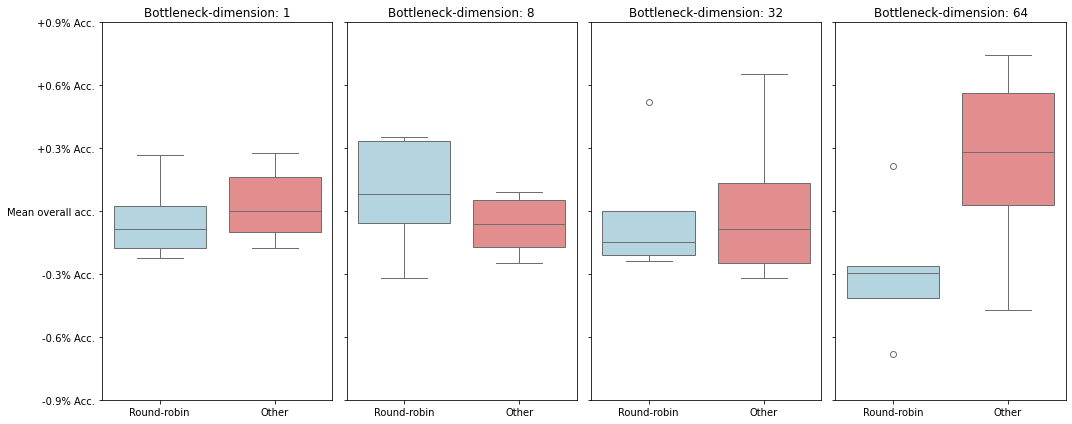

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import string

# --- Annahme: Die Listen accuracy_around_1, accuracy_other_1, ..., accuracy_other_64 sind bereits gefüllt ---

# Daten für die vier Boxplots (jeweils 2 Boxen)
data_group1 = [accuracy_around_1, accuracy_other_1]
data_group2 = [accuracy_around_8, accuracy_other_8]
data_group3 = [accuracy_around_32, accuracy_other_32]
data_group4 = [accuracy_around_64, accuracy_other_64]

# Beschriftungen für die Boxen jeder Gruppe
labels = ['Round-robin', 'Other']

# Farben für die Boxen
colors = ['lightblue', 'lightcoral']

# --- Erstellen der Boxplots ---
plt.figure(figsize=(15, 6))  # Größe der Abbildung anpassen

# Definiere die variablen Y-Achsen-Schritte für jede Bottleneck-Dimension
y_step = {1: 0.003, 8: 0.003, 32: 0.003, 64: 0.003}  # Beispielwerte, anpassbar

# Funktion zum Erstellen eines einzelnen Boxplots mit angepasster Y-Achse
def create_boxplot(data, title, subplot_index, y_step_value, y_label=False):
    plt.subplot(1, 4, subplot_index)
    sns.boxplot(data=data, palette=colors)
    plt.title(title)
    plt.xticks(range(len(labels)), labels)

    # Berechne den Mittelwert aller Daten in dieser Gruppe
    all_data = np.concatenate(data)
    mean_accuracy = np.mean(all_data) if all_data.size > 0 else 0.5  # Standardwert, falls keine Daten

    # Setze die Y-Achsenbegrenzungen basierend auf dem Mittelwert und dem variablen Schritt
    lower_bound = mean_accuracy - 3 * y_step_value
    upper_bound = mean_accuracy + 3 * y_step_value
    plt.ylim(lower_bound, upper_bound)

    # Definiere die Y-Tick-Positionen und Beschriftungen
    yticks = np.linspace(lower_bound, upper_bound, 7)
    yticklabels = []
    for i in range(-3, 4):
        if i < 0:
            yticklabels.append(f"{round(i*y_step_value * 100, 3)}% Acc.")
        elif i == 0:
            yticklabels.append("Mean overall acc.")
        else:
            yticklabels.append(f"+{round(i*y_step_value * 100, 3)}% Acc.")
    if y_label:        
        plt.yticks(yticks, yticklabels)
    else:
        plt.yticks(yticks, ["" for i in range(7)])
# Erster Boxplot
create_boxplot(data_group1, 'Bottleneck-dimension: 1', 1, y_step[1], y_label=True)

# Zweiter Boxplot
create_boxplot(data_group2, 'Bottleneck-dimension: 8', 2, y_step[8])

# Dritter Boxplot
create_boxplot(data_group3, 'Bottleneck-dimension: 32', 3, y_step[32])

# Vierter Boxplot
create_boxplot(data_group4, 'Bottleneck-dimension: 64', 4, y_step[64])

plt.tight_layout()  # Verhindert Überlappungen

# Speichern der Abbildung als PNG-Datei
filename = "vier_boxplots_umbenannte_yticks_abc.png"
output_dir = "local_saved_graphics"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, filename)
plt.savefig(output_file)

print(f"Die PNG-Datei '{output_file}' wurde erstellt.")

plt.show()

### Ohne fliers

Die PNG-Datei 'local_saved_graphics/vier_boxplots_ohne_outlier_mit_langen_whisker.png' wurde erstellt.
Outlier-Punkte werden nicht angezeigt, und die Whisker erstrecken sich über den gesamten Datenbereich.


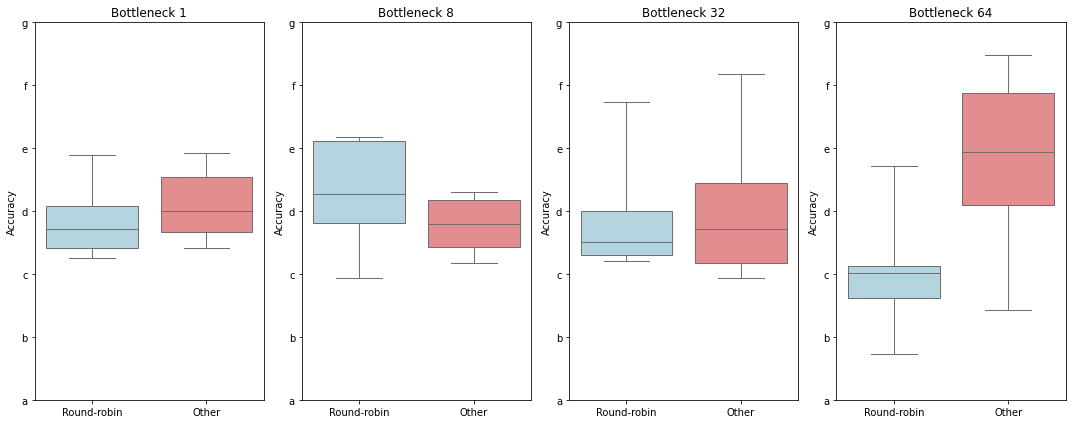

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import string

# --- Annahme: Die Listen accuracy_around_1, accuracy_other_1, ..., accuracy_other_64 sind bereits gefüllt ---

# Daten für die vier Boxplots (jeweils 2 Boxen)
data_group1 = [accuracy_around_1, accuracy_other_1]
data_group2 = [accuracy_around_8, accuracy_other_8]
data_group3 = [accuracy_around_32, accuracy_other_32]
data_group4 = [accuracy_around_64, accuracy_other_64]

# Beschriftungen für die Boxen jeder Gruppe
labels = ['Round-robin', 'Other']

# Farben für die Boxen
colors = ['lightblue', 'lightcoral']

# --- Erstellen der Boxplots ---
plt.figure(figsize=(15, 6))  # Größe der Abbildung anpassen

# Definiere die variablen Y-Achsen-Schritte für jede Bottleneck-Dimension
y_step = {1: 0.003, 8: 0.003, 32: 0.003, 64: 0.003}  # Beispielwerte, anpassbar

# Funktion zum Erstellen eines einzelnen Boxplots mit angepasster Y-Achse
def create_boxplot(data, title, subplot_index, y_step_value):
    plt.subplot(1, 4, subplot_index)
    sns.boxplot(data=data, palette=colors, showfliers=False, whis=np.inf)  # showfliers=False beibehalten, whis=np.inf hinzugefügt
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xticks(range(len(labels)), labels)

    # Berechne den Mittelwert aller Daten in dieser Gruppe
    all_data = np.concatenate(data)
    mean_accuracy = np.mean(all_data) if all_data.size > 0 else 0.5  # Standardwert, falls keine Daten

    # Setze die Y-Achsenbegrenzungen basierend auf dem Mittelwert und dem variablen Schritt
    lower_bound = mean_accuracy - 3 * y_step_value
    upper_bound = mean_accuracy + 3 * y_step_value
    plt.ylim(lower_bound, upper_bound)

    # Definiere die Y-Tick-Positionen und Beschriftungen
    yticks = np.linspace(lower_bound, upper_bound, 7)
    yticklabels = list(string.ascii_lowercase[:7])  # Erstellt ['a', 'b', 'c', 'd', 'e', 'f', 'g']
    plt.yticks(yticks, yticklabels)

# Erster Boxplot
create_boxplot(data_group1, 'Bottleneck 1', 1, y_step[1])

# Zweiter Boxplot
create_boxplot(data_group2, 'Bottleneck 8', 2, y_step[8])

# Dritter Boxplot
create_boxplot(data_group3, 'Bottleneck 32', 3, y_step[32])

# Vierter Boxplot
create_boxplot(data_group4, 'Bottleneck 64', 4, y_step[64])

plt.tight_layout()  # Verhindert Überlappungen

# Speichern der Abbildung als PNG-Datei
filename = "vier_boxplots_ohne_outlier_mit_langen_whisker.png"
output_dir = "local_saved_graphics"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, filename)
plt.savefig(output_file)

print(f"Die PNG-Datei '{output_file}' wurde erstellt.")
print("Outlier-Punkte werden nicht angezeigt, und die Whisker erstrecken sich über den gesamten Datenbereich.")

plt.show()

## Forgetting

In [4]:
def get_forgetting(runs, dataset_names, data):
    for run in runs:
        config = run.config
        summary = run.summary
        
        dataset = config.get("dataset")
        selection_method = config.get("selection_method")
        run_id = run.id
        state = run.state
        num_E = config.get("moe_max_experts")



        if state == "finished" and dataset in dataset_names and (selection_method == "around" or selection_method == "inv_ws_div"):
            # Get the history of the run
            history = run.history()

            run_data = {
                "run_id": run_id,
                "dataset": dataset,
                "selection_method": selection_method           
                }

            # End accuracy of tasks
            for key, value in summary.items():
                if key.startswith("task_") and key.endswith("/acc") and key != "task_mean/acc" and key != "task_wmean/acc":
                    t = int(key.split("_")[1].split("/")[0])

                    # is an initial task
                    if num_E <= t:
                        continue

                    key = "end_" + key
                    run_data[key] = value

            # Initial accuracy of tasks
            for line in history.items():
                key = line[0]
                if key.startswith("task_") and key.endswith("/acc") and key != "task_mean/acc" and key != "task_wmean/acc":
                    t = int(key.split("_")[1].split("/")[0])

                    # is an initial task
                    if num_E <= t:
                        continue

                    values = line[1]
                    filtered_values = values[~np.isnan(values)]
                    index = num_E - t - 1
                    base_acc = filtered_values.iloc[index]
                    key = "initial_" + key
                    run_data[key] = base_acc
            

            data.append(run_data)
    return data

def get_average_forgetting(df, num_tasks=5):
    forgetting_values = []
    for index, row in df.iterrows():
        row_forgetting = []
        for i in range(num_tasks):  # Assuming there are tasks 0 to 4
            end_col = f'end_task_{i}/acc'
            initial_col = f'initial_task_{i}/acc'
            if end_col in row and initial_col in row and pd.notna(row[end_col]) and pd.notna(row[initial_col]):
                forgetting = row[initial_col] - row[end_col]
                row_forgetting.append(forgetting)
        # Calculate the average forgetting for the row, ignoring NaNs
        avg_forgetting = np.nanmean(row_forgetting)
        forgetting_values.append(avg_forgetting)
    return forgetting_values

In [34]:
sweeps_around =[
    "belaschindler-university-hamburg/0schindl-LayUp_sweeps_question1_results/cyom2yi0",
    "belaschindler-university-hamburg/0schindl-LayUp_sweeps_question1_results/j1eqzi38",
    "belaschindler-university-hamburg/0schindl-LayUp_sweeps_question1_results/hufbsf9l"
    ]
around_datasets = [
    ["cifar100", "cub", "imageneta", "omnibenchmark"],
    ["imagenetr", "cars"],
    ["dil_imagenetr", "limited_domainnet"]
    ]
around_data = []
for i, link in enumerate(sweeps_around):
    datasets = around_datasets[i]
    sweep = api.sweep(link)
    runs = sweep.runs 
    around_data = get_forgetting(runs, datasets, around_data)
    print(f"###### {i} ######")

around_data = pd.DataFrame(around_data)
around_data['average_forgetting'] = get_average_forgetting(around_data)
around_data["average_forgetting"] *= 100

###### 0 ######
###### 1 ######
###### 2 ######


In [35]:
around_data = around_data.drop(columns=['run_id', 'selection_method'])

# Calculate the mean for each dataset
around_data = around_data.groupby('dataset').mean()
around_data = around_data.reset_index()


print("\nDataFrame der Sweep-Runs:")
pd.set_option('display.width', 5000)
pd.set_option('display.max_colwidth', None)
print(around_data.sort_values(by=['dataset']))
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


DataFrame der Sweep-Runs:
             dataset  end_task_0/acc  end_task_1/acc  end_task_2/acc  end_task_3/acc  end_task_4/acc  initial_task_2/acc  initial_task_3/acc  initial_task_4/acc  initial_task_0/acc  initial_task_1/acc  average_forgetting
0               cars        0.496033        0.292426        0.306835        0.286099        0.279389            0.432258            0.426269            0.394237            0.625123            0.416785           12.677777
1           cifar100        0.780000        0.777200        0.769200        0.761200        0.798800            0.827800            0.837000            0.860600            0.840400            0.820400            5.996000
2                cub        0.720846        0.710292        0.727100        0.692871        0.713600            0.805399            0.794546            0.792935            0.814091            0.808502            9.015297
3      dil_imagenetr        0.838925        0.708880        0.669067        0.776777     

In [36]:
sweeps_ws =[
    "belaschindler-university-hamburg/0schindl-LayUp_sweeps_question1_results/p7zmthx9", # CIL
    "belaschindler-university-hamburg/0schindl-LayUp_sweeps_question1_results/jdpa9z1x", # Cars
    "belaschindler-university-hamburg/0schindl-LayUp_sweeps_question1_results/hxigp6ck", # imagenet r
    "belaschindler-university-hamburg/0schindl-LayUp_sweeps_question1_results/cjddpel4", # imagenet a
    "belaschindler-university-hamburg/0schindl-LayUp_sweeps_question1_results/6kim8tiu"  # DIL
    ]
ws_datasets = [
    ["cifar100", "cub", "imageneta", "omnibenchmark"],
    ["cars"],
    ["imagenetr"],
    ["imageneta"],
    ["dil_imagenetr", "limited_domainnet"]
    ]
ws_data = []
for i, link in enumerate(sweeps_ws):
    datasets = ws_datasets[i]
    sweep = api.sweep(link)
    runs = sweep.runs 
    ws_data = get_forgetting(runs, datasets, ws_data)
    print(f"###### {i} ######")

ws_data = pd.DataFrame(ws_data)
ws_data['average_forgetting'] = get_average_forgetting(ws_data)
ws_data["average_forgetting"] *= 100

###### 0 ######
###### 1 ######
###### 2 ######
###### 3 ######
###### 4 ######


In [37]:
ws_data = ws_data.drop(columns=['run_id', 'selection_method'])

# Calculate the mean for each dataset
ws_data = ws_data.groupby('dataset').mean()
ws_data = ws_data.reset_index()


print("\nDataFrame der Sweep-Runs:")
pd.set_option('display.width', 5000)
pd.set_option('display.max_colwidth', None)
print(ws_data.sort_values(by=['dataset']))
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


DataFrame der Sweep-Runs:
             dataset  end_task_0/acc  end_task_1/acc  end_task_2/acc  end_task_3/acc  end_task_4/acc  initial_task_2/acc  initial_task_1/acc  initial_task_0/acc  initial_task_3/acc  initial_task_4/acc  average_forgetting
0               cars        0.504563        0.319523        0.334730        0.325525        0.309401            0.421526            0.401964            0.604980            0.448128            0.384185            9.340815
1           cifar100        0.778000        0.773400        0.772800        0.769600        0.800200            0.825600            0.819600            0.838800            0.836800            0.860000            5.736000
2                cub        0.723263        0.719752        0.725454        0.694261        0.712105            0.809228            0.814334            0.808099            0.796508            0.793605            8.938772
3      dil_imagenetr        0.857204        0.701503        0.651200        0.784834     

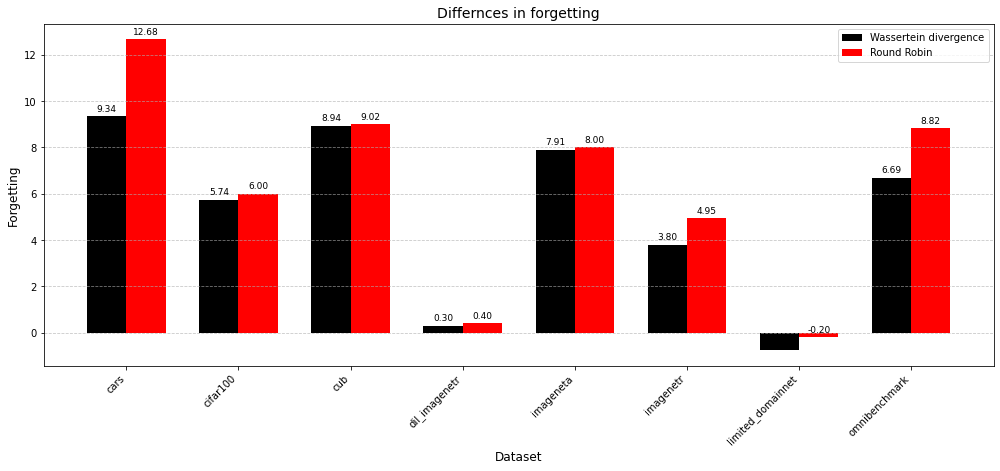

Die schöne Säulendiagramm-Grafik wurde als 'forgetting.png' gespeichert.


In [38]:
# Benenne die Spalte "average forgetting" in den DataFrames um, um die Gruppenzugehörigkeit zu kennzeichnen
df1 = ws_data.rename(columns={'average_forgetting': 'average forgetting WS'})
df2 = around_data.rename(columns={'average_forgetting': 'average forgetting RR'})

# Führe die DataFrames basierend auf der Spalte "dataset" zusammen (linker Join, um alle Datasets aus df1 zu behalten)
df_merged = pd.merge(df1[['dataset', 'average forgetting WS']], df2[['dataset', 'average forgetting RR']], on='dataset', how='left')

# Datasets (Namen für die X-Achse)
datasets = df_merged["dataset"]

# Werte für die jeweils zwei Säulen pro Dataset
values1 = df_merged["average forgetting WS"]
values2 = df_merged["average forgetting RR"]

# Namen für die Legende
group_labels = ['Wassertein divergence', 'Round Robin']

# Farben für die Säulen
colors = ["000000" , "#FF0000"]  # Freundlichere Farben

# Positionen der Gruppen auf der X-Achse
x = np.arange(len(datasets))
width = 0.35  # Breite der Säulen

fig, ax = plt.subplots(figsize=(14, 7))  # Größe der Abbildung angepasst

rects1 = ax.bar(x - width/2, values1, width, label=group_labels[0], color=colors[0])
rects2 = ax.bar(x + width/2, values2, width, label=group_labels[1], color=colors[1])

# Beschriftungen, Titel und X-Achsenticks mit verbesserter Formatierung
ax.set_ylabel('Forgetting', fontsize=12)
ax.set_xlabel('Dataset', fontsize=12)
ax.set_title('Differnces in forgetting', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(datasets, fontsize=10, rotation=45, ha='right') # Rotierte Beschriftungen
ax.legend(fontsize=10)
ax.grid(axis='y', linestyle='--', alpha=0.7) # Horizontales Gitter für bessere Lesbarkeit

# Füge Wertebeschriftungen zu den Säulen hinzu (optional, für mehr Details)
def autolabel(rects):
    """Beschriftet die Säulen mit ihren Werten."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 Punkte vertikal versetzt
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

autolabel(rects1)
autolabel(rects2)

fig.tight_layout(rect=[0, 0, 1, 0.95]) # Anpassung des Layouts für den Titel

# Speichern der Abbildung als PNG-Datei mit höherer Auflösung
filename = "forgetting.png"
output_dir = "local_saved_graphics"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, filename)
plt.savefig(output_file)

plt.show()

print(f"Die schöne Säulendiagramm-Grafik wurde als '{filename}' gespeichert.")

## Forgetting Gini

In [56]:
gini_table = []
# Wasserstein div
for i, link in enumerate(sweeps_ws):
    datasets = ws_datasets[i]
    sweep = api.sweep(link)
    runs = sweep.runs 
    attributes_config = ["dataset", "selection_method", "seed"]
    attributes_summary = ["task_mean/acc"]


    data = get_sweep_data(runs, attributes_config, attributes_summary, include_run_id=False, gini=True)
    for e in data:
        if e["dataset"] in datasets:
            gini_table.append(e)


gini_table = pd.DataFrame(gini_table)


In [57]:
print("\nDataFrame der Sweep-Runs:")
pd.set_option('display.width', 5000)
pd.set_option('display.max_colwidth', None)
print(gini_table.sort_values(by=['dataset', "selection_method"]))
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


DataFrame der Sweep-Runs:
              dataset selection_method  seed  task_mean/acc  gini
15               cars       inv_ws_div  2002       0.331595  0.64
16               cars       inv_ws_div  2004       0.356273  0.72
17               cars       inv_ws_div  2003       0.320736  0.32
18               cars       inv_ws_div  2001       0.359519  0.80
19               cars       inv_ws_div  2000       0.351782  0.72
10           cifar100       inv_ws_div  2000       0.769500  0.56
11           cifar100       inv_ws_div  2004       0.771100  0.80
12           cifar100       inv_ws_div  2003       0.771800  0.56
13           cifar100       inv_ws_div  2002       0.770300  0.80
14           cifar100       inv_ws_div  2001       0.773700  0.72
5                 cub       inv_ws_div  2004       0.722443  0.72
6                 cub       inv_ws_div  2003       0.727207  0.72
7                 cub       inv_ws_div  2002       0.722427  0.80
8                 cub       inv_ws_div  2001     

In [59]:
df = gini_table.copy()
grouped_by_dataset = df.groupby('dataset')
for name, group  in grouped_by_dataset:
    print(name)
    print(group)

cars
   dataset selection_method  seed  task_mean/acc  gini
15    cars       inv_ws_div  2002       0.331595  0.64
16    cars       inv_ws_div  2004       0.356273  0.72
17    cars       inv_ws_div  2003       0.320736  0.32
18    cars       inv_ws_div  2001       0.359519  0.80
19    cars       inv_ws_div  2000       0.351782  0.72
cifar100
     dataset selection_method  seed  task_mean/acc  gini
10  cifar100       inv_ws_div  2000         0.7695  0.56
11  cifar100       inv_ws_div  2004         0.7711  0.80
12  cifar100       inv_ws_div  2003         0.7718  0.56
13  cifar100       inv_ws_div  2002         0.7703  0.80
14  cifar100       inv_ws_div  2001         0.7737  0.72
cub
  dataset selection_method  seed  task_mean/acc  gini
5     cub       inv_ws_div  2004       0.722443  0.72
6     cub       inv_ws_div  2003       0.727207  0.72
7     cub       inv_ws_div  2002       0.722427  0.80
8     cub       inv_ws_div  2001       0.730753  0.72
9     cub       inv_ws_div  2000       0

In [60]:
for name, group in grouped_by_dataset:
    gini = group["gini"]
    print(f"Mean Gini {name}: {round(sum(gini)/len(gini), 3)}")

Mean Gini cars: 0.64
Mean Gini cifar100: 0.688
Mean Gini cub: 0.752
Mean Gini dil_imagenetr: 0.672
Mean Gini imageneta: 0.608
Mean Gini imagenetr: 0.768
Mean Gini limited_domainnet: 0.8
Mean Gini omnibenchmark: 0.608


### OLD

In [90]:
_433_forgetting = [
    "belaschindler-university-hamburg/0schindl-LayUp_sweeps_question1_results/cyom2yi0", # CIL normal
    "belaschindler-university-hamburg/0schindl-LayUp_sweeps_question1_results/j1eqzi38", # CIL cosine
    "belaschindler-university-hamburg/0schindl-LayUp_sweeps_question1_results/hufbsf9l"  # DIL
    ]

sweep = api.sweep(_433_forgetting[0])
sweep2 = api.sweep(_433_forgetting[1])
sweep3 = api.sweep(_433_forgetting[2])
runs1 = sweep.runs
runs2 = sweep2.runs
runs3 = sweep3.runs

def get_forgetting(runs, data):
    for run in runs:
        config = run.config
        summary = run.summary
        
        dataset = config.get("dataset")
        selection_method = config.get("selection_method")
        run_id = run.id
        state = run.state
        num_E = config.get("moe_max_experts")



        if state == "finished" and (selection_method == "around" or selection_method == "inv_ws_div"):
            # Get the history of the run
            history = run.history()

            run_data = {
                "run_id": run_id,
                "dataset": dataset,
                "selection_method": selection_method           
                }

            # End accuracy of tasks
            for key, value in summary.items():
                if key.startswith("task_") and key.endswith("/acc") and key != "task_mean/acc" and key != "task_wmean/acc":
                    t = int(key.split("_")[1].split("/")[0])

                    # is an initial task
                    if num_E <= t:
                        continue

                    key = "end_" + key
                    run_data[key] = value

            # Initial accuracy of tasks
            for line in history.items():
                key = line[0]
                if key.startswith("task_") and key.endswith("/acc") and key != "task_mean/acc" and key != "task_wmean/acc":
                    t = int(key.split("_")[1].split("/")[0])

                    # is an initial task
                    if num_E <= t:
                        continue

                    values = line[1]
                    filtered_values = values[~np.isnan(values)]
                    index = num_E - t - 1
                    base_acc = filtered_values.iloc[index]
                    key = "initial_" + key
                    run_data[key] = base_acc
            
            # Overall perfomrance drop
            mean_accs = history["task_mean/acc"]
            filtered_values = mean_accs[~np.isnan(mean_accs)]

            run_data["inital_mean_acc"] = filtered_values.iloc[num_E - 1]
            run_data["end_mean_acc"] = filtered_values.iloc[-1]

            data.append(run_data)
            

            data.append(run_data)
    return data

def get_bwt(runs, dataset_names, data):
    for run in runs:
        config = run.config
        summary = run.summary
        
        dataset = config.get("dataset")
        selection_method = config.get("selection_method")
        run_id = run.id
        state = run.state
        num_E = config.get("moe_max_experts")



        if state == "finished" and dataset in dataset_names:
            # Get the history of the run
            history = run.history()

            run_data = {
                "run_id": run_id,
                "dataset": dataset,
                "selection_method": selection_method           
                }

            # End accuracy of tasks
            for key, value in summary.items():
                if key.startswith("task_") and key.endswith("/acc") and key != "task_mean/acc" and key != "task_wmean/acc":
                    t = int(key.split("_")[1].split("/")[0])

                    # is an initial task
                    if num_E <= t:
                        continue

                    key = "end_" + key
                    run_data[key] = value

            # Initial accuracy of tasks
            for line in history.items():
                key = line[0]
                if key.startswith("task_") and key.endswith("/acc") and key != "task_mean/acc" and key != "task_wmean/acc":
                    t = int(key.split("_")[1].split("/")[0])

                    # is an initial task
                    if num_E <= t:
                        continue

                    values = line[1]
                    filtered_values = values[~np.isnan(values)]
                    index = num_E - t - 1
                    base_acc = filtered_values.iloc[index]
                    key = "initial_" + key
                    run_data[key] = base_acc
            

            data.append(run_data)
    data = pd.DataFrame(data)
    return data

def get_average_forgetting(df, num_tasks=5):
    forgetting_values = []
    for index, row in df.iterrows():
        row_forgetting = []
        for i in range(num_tasks):  # Assuming there are tasks 0 to 4
            end_col = f'end_task_{i}/acc'
            initial_col = f'initial_task_{i}/acc'
            if end_col in row and initial_col in row and pd.notna(row[end_col]) and pd.notna(row[initial_col]):
                forgetting = row[initial_col] - row[end_col]
                row_forgetting.append(forgetting)
        # Calculate the average forgetting for the row, ignoring NaNs
        avg_forgetting = np.nanmean(row_forgetting)
        forgetting_values.append(avg_forgetting)
    return forgetting_values

'''
def get_mean_acc_dropout(runs, data):
    for run in runs:
        config = run.config
        
        dataset = config.get("dataset")
        selection_method = config.get("selection_method")
        run_id = run.id
        state = run.state
        num_E = config.get("moe_max_experts")



        if state == "finished" and (selection_method == "around" or selection_method == "inv_ws_div"):
            # Get the history of the run
            history = run.history()

            run_data = {
                "run_id": run_id,
                "dataset": dataset,
                "selection_method": selection_method,
                "inital_mean_acc": None,
                "end_mean_acc": None       
                }
            
            mean_accs = history["task_mean/acc"]
            filtered_values = mean_accs[~np.isnan(mean_accs)]

            run_data["inital_mean_acc"] = filtered_values.iloc[num_E - 1]
            run_data["end_mean_acc"] = filtered_values.iloc[-1]

            data.append(run_data)

    return data
    '''


'\ndef get_mean_acc_dropout(runs, data):\n    for run in runs:\n        config = run.config\n        \n        dataset = config.get("dataset")\n        selection_method = config.get("selection_method")\n        run_id = run.id\n        state = run.state\n        num_E = config.get("moe_max_experts")\n\n\n\n        if state == "finished" and (selection_method == "around" or selection_method == "inv_ws_div"):\n            # Get the history of the run\n            history = run.history()\n\n            run_data = {\n                "run_id": run_id,\n                "dataset": dataset,\n                "selection_method": selection_method,\n                "inital_mean_acc": None,\n                "end_mean_acc": None       \n                }\n            \n            mean_accs = history["task_mean/acc"]\n            filtered_values = mean_accs[~np.isnan(mean_accs)]\n\n            run_data["inital_mean_acc"] = filtered_values.iloc[num_E - 1]\n            run_data["end_mean_acc"] = filte

In [91]:
data = []
print("####### 1 #######")
data = get_forgetting(runs1, data=data)
print("####### 2 #######")
data = get_forgetting(runs2, data)
print("####### 3 #######")
data = get_forgetting(runs3, data)


# Add the average forgetting as a new column
data = pd.DataFrame(data)
data['average_forgetting'] = get_average_forgetting(data)
data["overall_performance_drop"] = data["inital_mean_acc"] - data["end_mean_acc"]
print(data.head())

####### 1 #######
####### 2 #######
####### 3 #######
     run_id    dataset selection_method  end_task_0/acc  end_task_1/acc  \
0  559k0h48  imageneta           around        0.403226        0.345679   
1  559k0h48  imageneta           around        0.403226        0.345679   
2  pgeegbte  imageneta           around        0.472000        0.382979   
3  pgeegbte  imageneta           around        0.472000        0.382979   
4  u6zng96s  imageneta           around        0.407895        0.341463   

   end_task_2/acc  end_task_3/acc  end_task_4/acc  initial_task_0/acc  \
0        0.428571        0.380368        0.320312            0.483871   
1        0.428571        0.380368        0.320312            0.483871   
2        0.357143        0.453552        0.378049            0.552000   
3        0.357143        0.453552        0.378049            0.552000   
4        0.431818        0.382979        0.372449            0.519737   

   initial_task_3/acc  initial_task_1/acc  initial_task_

In [92]:
df = data[["dataset", "selection_method", "average_forgetting", "overall_performance_drop"]].copy()
df.loc[:, "average_forgetting"] = df["average_forgetting"] * 100
df.loc[:, "overall_performance_drop"] = df["overall_performance_drop"] * 100


# Average forgetting of initial tasks per dataset and selection method
average_forgetting_grouped = df.groupby(['dataset', 'selection_method'])['average_forgetting'].mean().reset_index()
print("Average forgetting of initial tasks per selection_method per dataset:")
print(average_forgetting_grouped)
print("\n---")

average_performance_drop_grouped = df.groupby(['dataset', 'selection_method'])['overall_performance_drop'].mean().reset_index()
print("Average performance drop per selection_method per dataset:")
print(average_performance_drop_grouped)
print("\n---")


Average forgetting of initial tasks per selection_method per dataset:
     dataset selection_method  average_forgetting
0       cars           around           13.078436
1   cifar100           around            6.300000
2        cub           around            9.015297
3  imageneta           around            7.962394
4  imagenetr           around            4.953849

---
Average performance drop per selection_method per dataset:
     dataset selection_method  overall_performance_drop
0       cars           around                 12.576798
1   cifar100           around                  7.193333
2        cub           around                  8.105862
3  imageneta           around                  7.447219
4  imagenetr           around                 10.326134

---


## Correlation attempt, but not in paper

In [16]:
import pandas as pd
from scipy.stats import spearmanr

# Your provided dataframes
data = {'dataset': ['around', 'eucld_dist', 'inv_eucld_dist', 'inv_kl_div', 'inv_ws_div', 'kl_div', 'ws_div'],
        'cars': [33.5, 35.7, 38.3, 34.7, 36.0, 38.3, 36.2],
        'cddb': [61.7, 61.7, 61.7, 61.7, 61.7, 61.7, 61.7],
        'cifar100': [77.2, 77.0, 77.4, 77.3, 78.1, 77.0, 77.0],
        'cub': [72.2, 72.6, 72.5, 72.7, 73.1, 72.6, 72.7],
        'dil_imagenetr': [66.8, 66.5, 69.3, 68.4, 69.8, 66.0, 66.1],
        'imageneta': [39.7, 39.4, 40.1, 40.3, 40.0, 40.2, 39.1],
        'imagenetr': [65.9, 65.8, 67.6, 68.0, 67.0, 66.2, 66.6],
        'limited_domainnet': [41.7, 42.8, 42.6, 44.0, 44.7, 42.8, 43.4],
        'omnibenchmark': [58.8, 58.2, 56.4, 55.8, 59.0, 56.0, 58.8],
        'vtab': [78.4, 78.4, 78.4, 78.4, 78.4, 78.4, 78.4]}
performance_df = pd.DataFrame(data).set_index('dataset')

metrics_data = {'dataset': ['vtab', 'cub', 'limited_domainnet', 'cars', 'imageneta', 'imagenetr', 'cifar100', 'omnibenchmark', 'cddb', 'dil_imagenetr'],
                'label_entropy': [5.135257059384608, 7.6394892912115475, 8.430233055747799, 7.6068022766474614, 7.223263760979077, 7.484169242012397, 6.6438561897747395, 8.21848928301928, 0.9999986477207174, 7.468858110095726],
                'feature_entropy': [20.377330152154737, 22.693105913494797, 23.713624152781033, 22.493487834435626, 22.07118071497553, 23.90650034886013, 24.744814289938947, 25.300011063053734, 23.40133451907669, 24.12360943301993],
                'feature_variance': [1.3927473, 0.910093, 1.7145133, 0.71304107, 1.8043848, 1.735376, 1.4252658, 1.1842374, 1.4669995, 1.7321476],
                'interclass_similarity': [0.17165852, 0.25424278, 0.11973199, 0.40625358, 0.056862935, 0.08631205, 0.24176903, 0.08829499, 0.122920655, 0.093857355],
                'intra_class_similarity': [0.54155165, 0.628753, 0.26744395, 0.67079747, 0.1786454, 0.2761269, 0.47215694, 0.53636956, 0.12528166, 0.27955163]}
metrics_df = pd.DataFrame(metrics_data).set_index('dataset')

# Transpose the performance dataframe so selection methods are columns
performance_transposed_df = performance_df.T

# Merge the two dataframes on the 'dataset' index
merged_df = pd.merge(performance_transposed_df, metrics_df, left_index=True, right_index=True)

# Identify unique selection methods (now columns in merged_df)
selection_methods = performance_transposed_df.columns
dataset_metrics = metrics_df.columns

correlation_results = {}

for metric in dataset_metrics:
    correlation_results[metric] = {}
    for method in selection_methods:
        # Calculate Spearman rank correlation
        ranks_method = merged_df[method].rank()
        ranks_metric = merged_df[metric].rank()
        corr, _ = spearmanr(ranks_method, ranks_metric)
        correlation_results[metric][method] = corr

correlation_df_ranks = pd.DataFrame(correlation_results).T

print("Correlation between Dataset Metrics and Selection Method Ranking:")
print(correlation_df_ranks)

create_colored_table(correlation_df_ranks, "dataset_metrics_selection_method_correlation")



Correlation between Dataset Metrics and Selection Method Ranking:
                          around  eucld_dist  inv_eucld_dist  inv_kl_div  \
label_entropy          -0.418182   -0.418182       -0.418182   -0.418182   
feature_entropy         0.103030    0.103030        0.103030    0.103030   
feature_variance       -0.090909   -0.090909       -0.090909   -0.090909   
interclass_similarity   0.248485    0.248485        0.248485    0.248485   
intra_class_similarity  0.224242    0.224242        0.224242    0.224242   

                        inv_ws_div    kl_div    ws_div  
label_entropy            -0.418182 -0.406061 -0.406061  
feature_entropy           0.103030  0.090909  0.090909  
feature_variance         -0.090909 -0.078788 -0.078788  
interclass_similarity     0.248485  0.224242  0.224242  
intra_class_similarity    0.224242  0.212121  0.212121  
0
1
2.0
2.1
2.2
2.3
2.4
2.x
3
4


## Different T_E

In [23]:
_44_different_E_T = [
    "belaschindler-university-hamburg/0schindl-LayUp_sweeps_question1_results/rxdw6xbz",
    "belaschindler-university-hamburg/0schindl-LayUp_sweeps_question1_results/1gdatvy5", 
    "belaschindler-university-hamburg/0schindl-LayUp_sweeps_question1_results/sabim6l1" 
    ]

table_44 = []
for i , s in enumerate(_44_different_E_T):
    sweep = api.sweep(s)
    runs = sweep.runs

    attributes_config = ["T", "moe_max_experts"]
    attributes_summary = ["task_mean/acc"]

    data = get_sweep_data(runs, attributes_config, attributes_summary, include_run_id=False)
    for e in data:
        table_44.append(e)

df_sweep = pd.DataFrame(table_44)
df_sweep["task_mean/acc"] = df_sweep["task_mean/acc"].astype(float).round(3) * 100
pd.set_option('display.max_rows', None)

In [28]:
df = df_sweep[df_sweep["T"] != 100]
df = df.sort_values(by=["T", "moe_max_experts"])
df = df.rename(columns={"moe_max_experts": "num_experts", "T": "num_tasks", "task_mean/acc": "acc"})
print(df)

    num_tasks  num_experts   acc
22          1            1  84.2
18          2            1  83.0
21          2            2  82.8
20          5            1  79.8
19          5            2  79.5
17          5            5  80.1
16         10            1  78.5
15         10            2  78.1
14         10            5  77.4
13         10           10  77.8
12         20            1  76.5
11         20            2  76.6
10         20            5  76.5
9          20           10  76.6
8          20           20  76.6
28         25            1  76.1
27         25            2  76.3
26         25            5  76.2
25         25           10  76.1
24         25           20  76.3
23         25           25  76.2
7          50            1  76.0
6          50            2  75.9
5          50            5  75.9
4          50           10  76.0
3          50           20  76.0
2          50           50  76.0


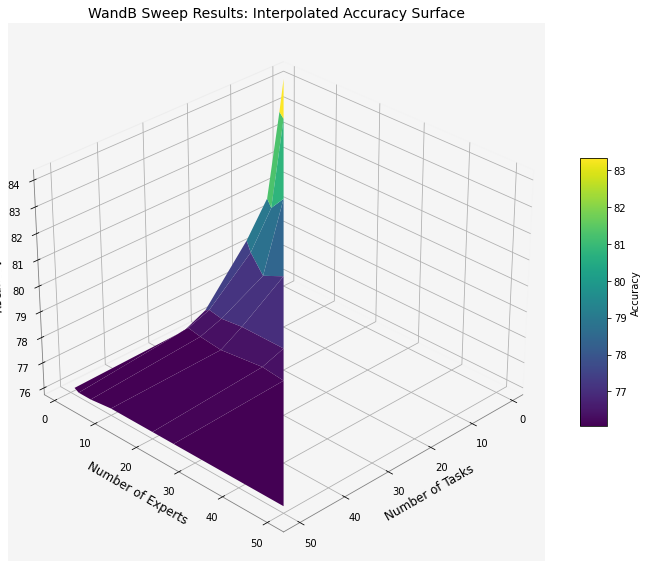

In [30]:
# Extract unique values for num_tasks and num_experts to create the grid
num_tasks_unique = np.unique(df["num_tasks"])
num_experts_unique = np.unique(df["num_experts"])

# Create a meshgrid from the unique values
X, Y = np.meshgrid(num_tasks_unique, num_experts_unique)

# Extract the accuracy values and corresponding coordinates
points = df[["num_tasks", "num_experts"]].values
values = df["acc"].values

# Define the fill value for the empty regions
fill_value = np.nan  # You can change this to 0 or another suitable value

# Interpolate the accuracy values onto the grid
Z = griddata(points, values, (X, Y), method='linear', fill_value=fill_value)

# Create the figure and 3D subplot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')

# Plot the surface with the interpolated data
surface = ax.plot_surface(X, Y, Z, cmap=sns.color_palette("viridis", as_cmap=True),
                          linewidth=0.2, antialiased=True, shade=True)

# Add a color bar for better interpretation
fig.colorbar(surface, shrink=0.5, aspect=10, label='Accuracy')

# Customize the axes labels and title for clarity
ax.set_xlabel('Number of Tasks', fontsize=12)
ax.set_ylabel('Number of Experts', fontsize=12)
ax.set_zlabel('Accuracy', fontsize=12)
ax.set_title('WandB Sweep Results: Interpolated Accuracy Surface', fontsize=14)

# Improve the viewing angle
ax.view_init(elev=30, azim=45)

# Add a subtle grid for orientation
ax.grid(True, linestyle='--', alpha=0.5)

# Make the background a bit lighter
ax.set_facecolor('whitesmoke')

# Tweak the appearance of the axes
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.line.set_color('gray')
ax.yaxis.line.set_color('gray')
ax.zaxis.line.set_color('gray')

# Ensure tight layout
plt.tight_layout()

# Save the figure with a high DPI
plt.savefig('./local_saved_graphics/different_T_E.png', dpi=400, bbox_inches='tight')
plt.show()
